## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [86]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [87]:
#Mount the google drive which has the dataset
from google.colab import drive
drive.mount('/content/gdrive')
root_path = "/content/gdrive/MyDrive/upgrad/Case_Study_Automatic_Ticket_Classification/complaints-2021-05-14_08_16.json"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [88]:
# Opening JSON file
f = open(root_path)

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [89]:
# Inspect the dataframe to understand the given data.
df=pd.json_normalize(data)
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [90]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [91]:
#Assign new column names
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]
df.head()

,_source.complaint_what_happened,_source.product,_source.sub_product
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [92]:
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})
df.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [93]:
# lets merge the category and sub-category this will help us in deciding the topics after NMF modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)
df.head()

,complaint_text,category
0,,Debt collection+Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection+Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card+General-purpose cr...
3,,Mortgage+Conventional home mortgage
4,,Credit card or prepaid card+General-purpose cr...


In [94]:
# lets check the nan complaints
df.complaint_text.isnull().sum()

0

In [95]:
# lets check the empty string complaints
len(df[df['complaint_text']==''])

57241

In [96]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_text']==''] = np.nan
df.complaint_text.isnull().sum()

57241

In [97]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_text'].isnull()]
df.complaint_text.isnull().sum()

0

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [98]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()

In [99]:
df.complaint_text = df.complaint_text.apply(lambda x: clean_text(x))
df.complaint_text.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint_text, dtype: object

In [100]:
#Write your function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatizer(text):
    doc = nlp(text)
    sent = [token.lemma_ for token in doc if not token.text in set(stopwords)]
    return ' '.join(sent)

In [101]:
import multiprocessing
def process_texts(texts):
    # Number of CPU cores available
    num_cores = multiprocessing.cpu_count()
    # Create a pool of worker processes
    with multiprocessing.Pool(processes=num_cores) as pool:
        # Map the lemmatize function to the list of texts and get the results
        results = pool.map(lemmatizer, texts)

    return results

In [102]:
# Lemmatize the complaints
df['lemma'] =process_texts(df.complaint_text)
df.head()

,complaint_text,category,lemma
1,good morning my name is xxxx xxxx and i apprec...,Debt collection+Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card+General-purpose cr...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,Checking or savings account+Checking account,grand son check deposit chase account fund cle...


In [103]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = df[['complaint_text', 'lemma', 'category']]

In [104]:
df_clean.head()

,complaint_text,lemma,category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account


In [105]:
#Write your function to extract the POS tags

def extract_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)

def process_pos_tags(texts):
    # Number of CPU cores available
    num_cores = multiprocessing.cpu_count()
    # Create a pool of worker processes
    with multiprocessing.Pool(processes=num_cores) as pool:
        # Map the lemmatize function to the list of texts and get the results
        results = pool.map(extract_pos_tags, texts)

    return results

df_clean['complaint_POS_removed'] =  process_pos_tags(df_clean.lemma)


<ipython-input-105-497db8f03536>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_text,lemma,category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help bank service chase debt verificat...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund bank account pa...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,Credit card or prepaid card+General-purpose cr...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,Credit card or prepaid card+General-purpose cr...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account+Checking account,xxxx risk consumer year trust mobile banking t...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,Credit card or prepaid card+General-purpose cr...,credit yrs credit card chase freedom problem t...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([9.236e+03, 6.356e+03, 2.725e+03, 1.276e+03, 7.570e+02, 2.750e+02,
        1.500e+02, 7.100e+01, 6.300e+01, 3.900e+01, 3.700e+01, 1.300e+01,
        1.100e+01, 1.100e+01, 8.000e+00, 8.000e+00, 7.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 7.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0. ,   248.5,   497. ,   745.5,   994. ,  1242.5,  1491. ,
         1739.5,  1988. ,  2236.5,  2485. ,  2733.5,  2982. ,  3230.5,
         3479. ,  3727.5,  3976. ,  4224.5,  4473. ,  4721.5,  4970. ,
         5218.5,  5467. ,  5715.5,  5964. ,  6212.5,  6461. ,  6709.5,
         6958. ,  7206.5,  7455. ,  7703.5,  7952. ,  8200.5,  8449. ,
         8697.5,  894

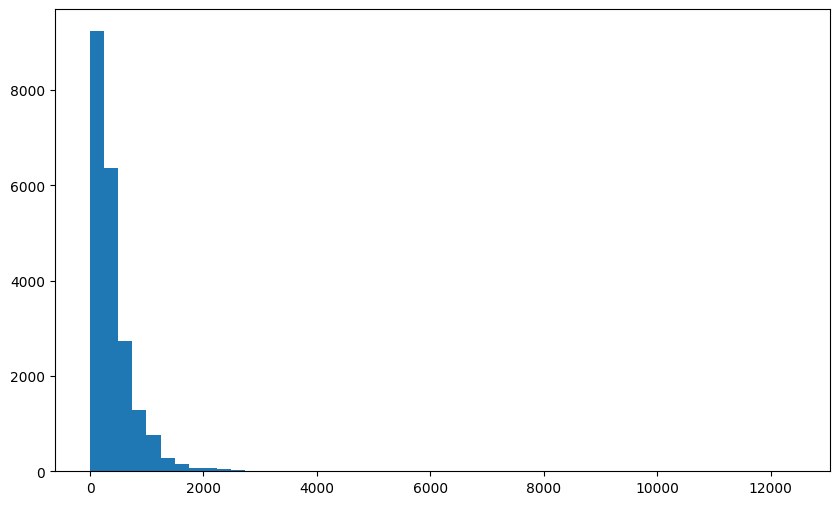

In [107]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize =(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [108]:
!pip install wordcloud

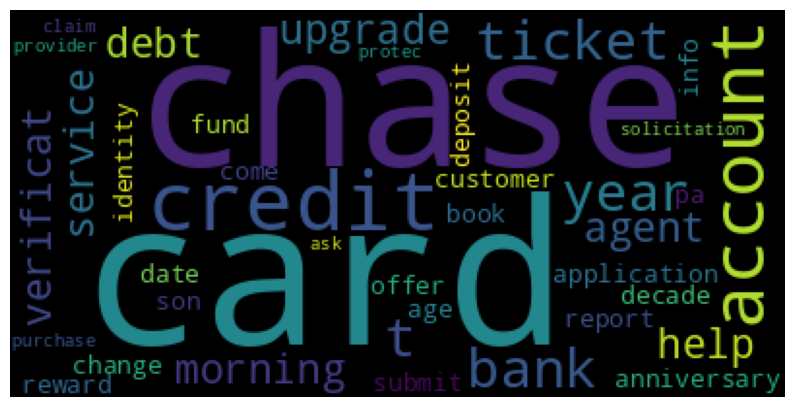

In [109]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize =(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [110]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean = df_clean.drop(['complaint_POS_removed'],axis = 1)

<ipython-input-110-8fce4b529747>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [111]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_n_bigram(text, ngram=1, top=None):

    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]


top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)



In [112]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams:\n')
top_30_unigrams[:10]

Top 10 unigrams:



[('chase', 53419),
 ('account', 40961),
 ('credit', 33554),
 ('xxxx', 31291),
 ('card', 29835),
 ('payment', 21064),
 ('bank', 17038),
 ('time', 15871),
 ('charge', 15292),
 ('day', 12831)]

In [113]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)

In [114]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams:\n')
top_30_bigrams[:10]

Top 10 bigrams:



[('credit card', 12773),
 ('credit report', 3893),
 ('chase credit', 3070),
 ('customer service', 2923),
 ('account chase', 2432),
 ('chase bank', 2120),
 ('check account', 2113),
 ('chase account', 2034),
 ('xxxx xxxx', 1954),
 ('contact chase', 1893)]

In [115]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [116]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams:\n')
top_30_trigrams[:10]

Top 10 trigrams:



[('chase credit card', 2196),
 ('credit card account', 1050),
 ('credit card company', 978),
 ('credit card chase', 738),
 ('xxxx credit card', 653),
 ('chase customer service', 559),
 ('inquiry credit report', 483),
 ('credit card credit', 437),
 ('charge credit card', 406),
 ('credit card xxxx', 386)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [117]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [118]:
#All masked texts has been removed
df_clean

,complaint_text,lemma,category,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help bank service chase debt verificat...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund bank account pa...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,Credit card or prepaid card+General-purpose cr...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,Credit card or prepaid card+General-purpose cr...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account+Checking account,risk consumer year trust mobile banking tell ...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,Credit card or prepaid card+General-purpose cr...,credit yrs credit card chase freedom problem t...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [119]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [120]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean)
tfidf.get_feature_names_out()[:10]


array(['aarp', 'abandonment', 'abatement', 'abbreviation', 'abd',
       'abhorrent', 'abide', 'ability', 'abovementione', 'abovereference'],
      dtype=object)

In [121]:
len(tfidf.get_feature_names_out())

6484

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [122]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [123]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

W1 = nmf_model.fit_transform(dtm)
H1 = nmf_model.components_

In [124]:
#nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6484

In [125]:
#Print the Top15 words for each of the topics
num_words=15

vocab = np.array(tfidf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]
topics

['account check money bank deposit chase fund day branch transfer number business transaction customer claim',
 'card credit chase balance account score limit year purchase point month application service reason time',
 'payment loan mortgage chase month modification time home pay year rate balance property statement date',
 'report inquiry credit information company reporting debt account file identity remove dispute theft score letter',
 'charge dispute fee chase transaction merchant claim purchase refund fraud service email time contact statement']

In [126]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" + str(i) for i in range(len(df_clean.Complaint_clean))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns=colnames, index=docnames)
significant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()


,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.03,0.00,0.02,0.02,0.01,0
Doc1,0.01,0.02,0.00,0.00,0.01,1
Doc2,0.00,0.03,0.00,0.04,0.00,3
Doc3,0.02,0.03,0.01,0.05,0.01,3
Doc4,0.07,0.00,0.01,0.00,0.00,0


In [127]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = significant_topic

In [128]:

 df_clean.head()

,complaint_text,lemma,category,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help bank service chase debt verificat...,0
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...,1
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...,3
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...,3
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund bank account pa...,0


In [129]:
#Print the first 5 Complaint for each of the Topics
df_temp = df_clean.groupby('Topic').head(5)
df_temp.sort_values('Topic')

,complaint_text,lemma,category,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help bank service chase debt verificat...,0
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund bank account pa...,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,Checking or savings account+Checking account,account debit card branch customer service rep...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,Vehicle loan or lease+Loan,mishandle account chase auto,0
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus c...,Checking or savings account+Checking account,account follow term account deposit bonus pa...,0
32,my chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,Credit card or prepaid card+General-purpose cr...,catering order place brother contact chase noo...,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,Credit card or prepaid card+General-purpose cr...,chase credit card datum credit report company ...,1
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...,1
50,i am a senior citizen that has been scammed by...,senior citizen scamme company xxxx xxxx pay ti...,Credit card or prepaid card+General-purpose cr...,citizen time share company misleading refund c...,1
52,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,Checking or savings account+Checking account,roommate chase debit card driver license money...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [130]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [131]:
df_clean.head(10)

,complaint_text,lemma,category,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help bank service chase debt verificat...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,card agent upgrade anniversary date change age...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket come offer ticket reward card info...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account fund bank account pa...,Bank Account services
15,can you please remove inquiry,remove inquiry,"Credit reporting, credit repair services, or o...",inquiry,Theft/Dispute Reporting
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,Checking or savings account+Checking account,account debit card branch customer service rep...,Bank Account services
20,during the summer months i experience a declin...,summer month experience decline income employm...,Vehicle loan or lease+Loan,summer month experience income employment requ...,Others
21,on xxxx i made a payment to an online retailer...,xxxx payment online retailer chase quick pay x...,"Money transfer, virtual currency, or money ser...",payment retailer chase pay website scam websi...,Mortgage/Loan
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,Credit card or prepaid card+General-purpose cr...,chase credit card datum credit report company ...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [132]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data

training_data = df_clean[['complaint_text','Topic']]

In [133]:
training_data.head()

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,Theft/Dispute Reporting
11,on while trying to book a xxxx xxxx ticket i...,Theft/Dispute Reporting
14,my grand son give me check for i deposit it in...,Bank Account services


In [134]:


## Reverse topic names mapping for supervised learning

reverse_topic_mapping = {
    'Bank Account services' :0,
    'Credit card or prepaid card':1,
    'Others':2,
    'Theft/Dispute Reporting':3,
    'Mortgage/Loan':4
}
#Replace Topics with Topic Names
training_data['Topic'] = training_data['Topic'].map(reverse_topic_mapping)
training_data.head()

<ipython-input-134-753e9b34ea30>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told b...,1
10,chase card was reported on however fraudulent ...,3
11,on while trying to book a xxxx xxxx ticket i...,3
14,my grand son give me check for i deposit it in...,0


In [135]:
training_data[['complaint_text','Topic']][training_data.Topic==2].head(10)

,complaint_text,Topic
20,during the summer months i experience a declin...,2
57,i have been trying to do a loan modification w...,2
58,i made a purchase of on xxxxxxxx i made paymen...,2
73,i have wired through one of chase branches in ...,2
81,i bought a new xxxx xxxx on xxxxxxxx from xxxx...,2
82,i recently called to ask chase bank why they r...,2
86,a student loan with chase bank they sold there...,2
99,my name is xxxx xxxx i have missed a payment i...,2
127,i am xxxx military member xxxx with the xxxx...,2
141,action taken by the company between the dates ...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [136]:
from sklearn.feature_extraction.text import TfidfTransformer
X = training_data.complaint_text
y = training_data.Topic

#Write your code to get the Vector count
count_vect = CountVectorizer()
X_vect = count_vect.fit_transform(X)

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_vect)

In [137]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=40, stratify=y)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [138]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



### Custom Classification Report

In [181]:
# utlity function to display the model report

def display_classification_report(model,metric):

    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
    metric.append(roc_auc_score_train)
    metric.append(roc_auc_score_test)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    precision_train,recall_train,fscore_train,support_train=precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test=precision_recall_fscore_support(y_test,y_test_pred,average='weighted')

    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)

    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(round(precision_train,2))
    metric.append(round(precision_test,2))
    metric.append(round(recall_train,2))
    metric.append(round(recall_test,2))
    metric.append(round(fscore_train,2))
    metric.append(round(fscore_test,2))

    print('Train Accuracy :',acc_score_train)
    print('Test Accuracy :',acc_score_test)

    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)

    print('Classification Report for Train:\n',model_report_train)
    print('Classification Report for Test:\n',model_report_test)


    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(12, 8))
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.xticks(rotation=80)

    plt.show();

### Stratified KFold Cross Validation

In [182]:
# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

### Custom GridSearchCV¶


In [183]:
# utility method to get the GridSearchCV object
def grid_search(model,folds,params,scoring):

    grid_search = GridSearchCV(model,
                                cv=folds,
                                param_grid=params,
                                scoring=scoring,
                                n_jobs=-1, verbose=1)
    return grid_search

In [185]:
# utility function to display the best score and parameters of the GridSearchCV model
def print_best_score_params(model):
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)

### Multinomial Naive Bayes Classification

ROC AUC Score Train: 0.95
ROC AUC Score Test: 0.93
Train Accuracy : 0.68
Test Accuracy : 0.64
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.56      0.96      0.71      4332
           1       0.81      0.50      0.62      3110
           2       0.74      0.89      0.81      3802
           3       0.97      0.20      0.34      1632
           4       0.88      0.47      0.62      2928

    accuracy                           0.68     15804
   macro avg       0.79      0.60      0.62     15804
weighted avg       0.76      0.68      0.66     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.52      0.95      0.67      1444
           1       0.77      0.41      0.54      1037
           2       0.71      0.85      0.78      1267
           3       0.96      0.17      0.29       544
           4       0.86      0.40      0.55       976

    accuracy            

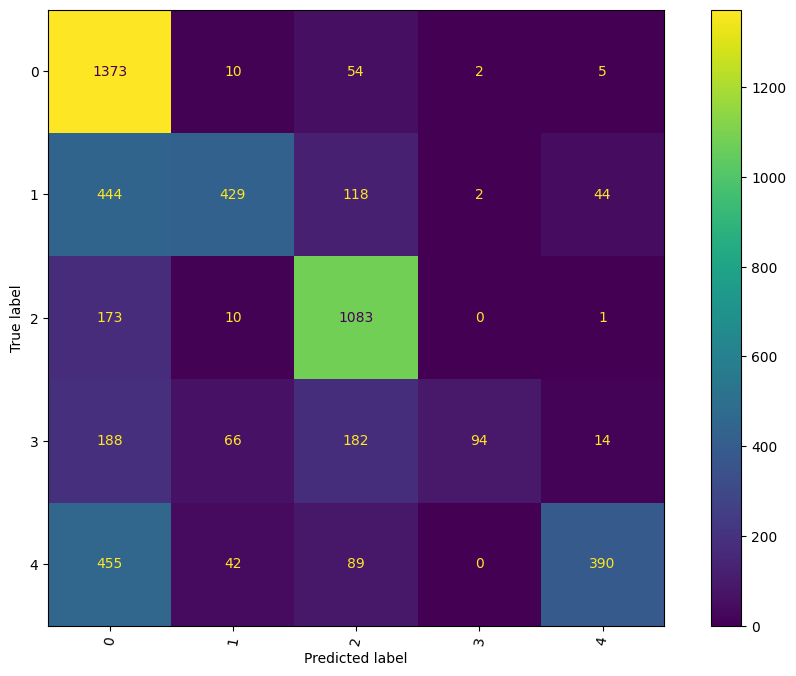

In [184]:
# Multinomial Naive Bayes Classification

# create MNB model object
mnb = MultinomialNB()
# fit model
mnb.fit(X_train, y_train)
# display classification report
metric1=[]
display_classification_report(mnb,metric1)

### Logistic Regression Classification

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 0.95
Test Accuracy : 0.9
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      4332
           1       0.95      0.94      0.95      3110
           2       0.95      0.98      0.96      3802
           3       0.95      0.88      0.92      1632
           4       0.95      0.91      0.93      2928

    accuracy                           0.95     15804
   macro avg       0.95      0.94      0.94     15804
weighted avg       0.95      0.95      0.95     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      1444
           1       0.91      0.89      0.90      1037
           2       0.92      0.96      0.94      1267
           3       0.93      0.81      0.87       544
           4       0.89      0.85      0.87       976

    accuracy              

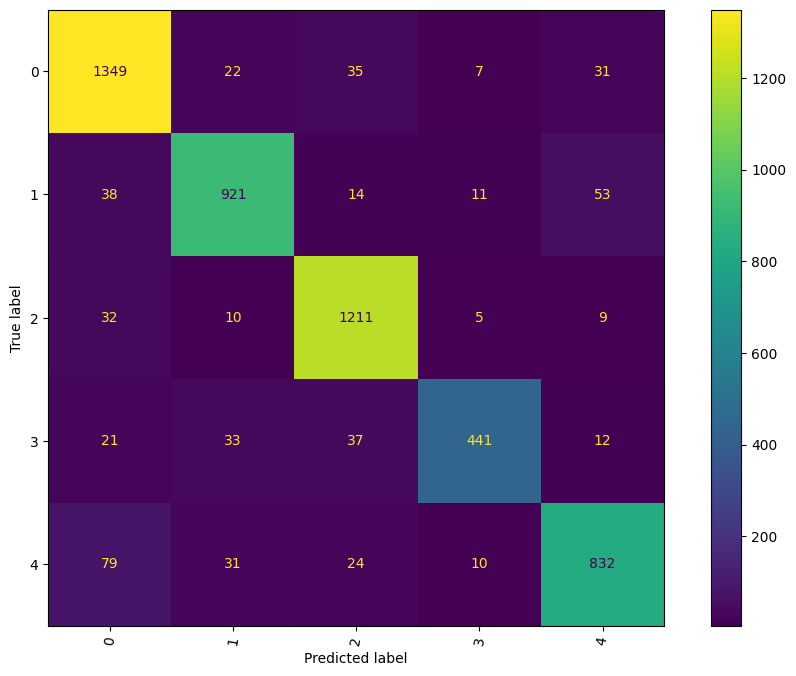

In [198]:
# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
metric2=[]
display_classification_report(log_reg,metric2)

### Decision Tree Classification

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.85
Train Accuracy : 1.0
Test Accuracy : 0.76
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4332
           1       1.00      1.00      1.00      3110
           2       1.00      1.00      1.00      3802
           3       1.00      1.00      1.00      1632
           4       1.00      1.00      1.00      2928

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77      1444
           1       0.75      0.76      0.76      1037
           2       0.83      0.83      0.83      1267
           3       0.74      0.75      0.74       544
           4       0.67      0.67      0.67       976

    accuracy              

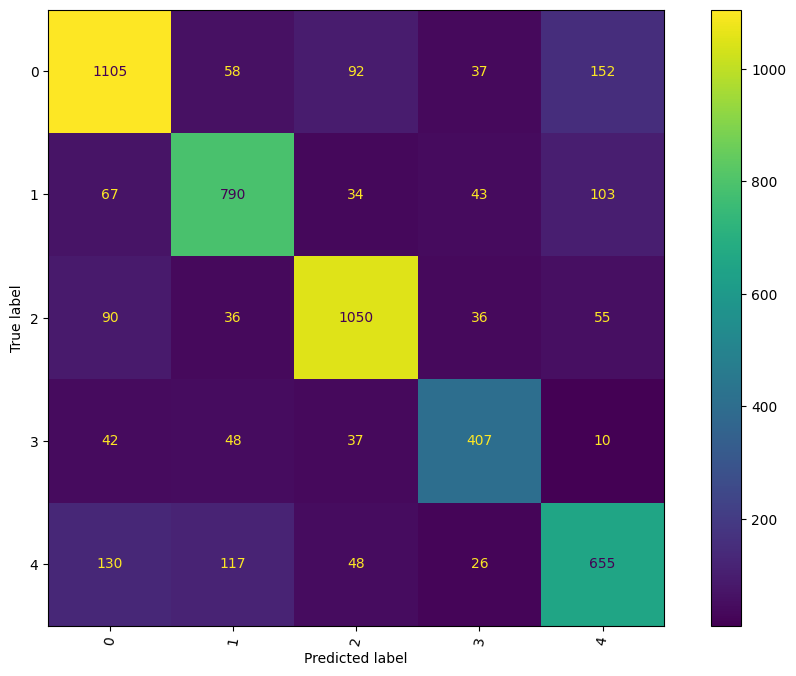

In [145]:
# Decision Tree Classification
dtc = DecisionTreeClassifier(random_state=40)
# fit model
dtc.fit(X_train,y_train)
# Decision Tree Classification Report
metric3=[]
display_classification_report(dtc,metric3)

### Random Forest Classification

OOB SCORE : 0.8251075677043787
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.98
Train Accuracy : 1.0
Test Accuracy : 0.83
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4332
           1       1.00      1.00      1.00      3110
           2       1.00      1.00      1.00      3802
           3       1.00      1.00      1.00      1632
           4       1.00      1.00      1.00      2928

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.78      0.93      0.85      1444
           1       0.84      0.78      0.81      1037
           2       0.85      0.91      0.88      1267
           3       0.92      0.69      0.79       544
           4       0.86      0.72      0.78       

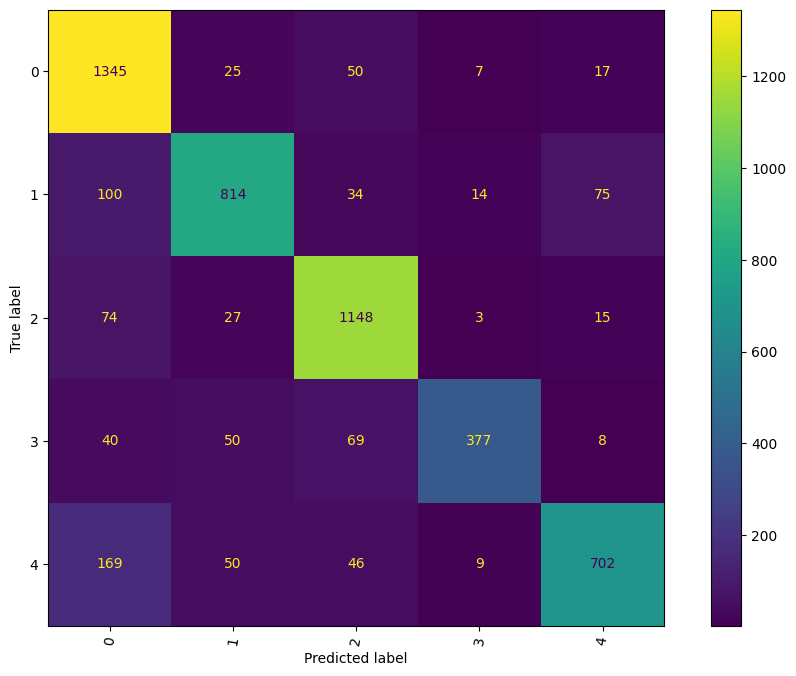

In [146]:
# Random Forest Classification

rf = RandomForestClassifier(n_estimators = 500,random_state=40, n_jobs = -1,oob_score=True)
# fit model
rf.fit(X_train,y_train)

# oob score
print('OOB SCORE :',rf.oob_score_)

# Random Forest Classification Report
metric4=[]
display_classification_report(rf,metric4)

## Hyper parameter tuning with GridSearchCV

### Multinomial Naive Bayes with GridSearchCV

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.7549978976369439
Best Hyperparameters:  {'alpha': 0.1}
ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.95
Train Accuracy : 0.85
Test Accuracy : 0.76
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87      4332
           1       0.85      0.79      0.82      3110
           2       0.86      0.91      0.88      3802
           3       0.89      0.70      0.78      1632
           4       0.89      0.80      0.84      2928

    accuracy                           0.85     15804
   macro avg       0.86      0.83      0.84     15804
weighted avg       0.85      0.85      0.85     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79      1444
           1       0.73      0.61      0.66      1037
           2       0.78      0.87      0.82      1267
   

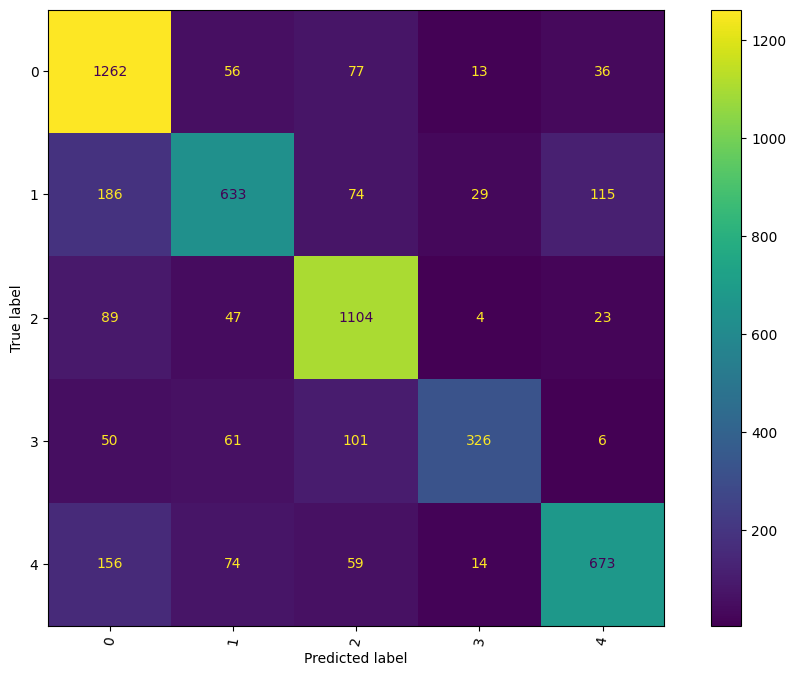

In [147]:
# Multinomial Naive Bayes with GridSearchCV

mnb = MultinomialNB()

mnb_params = {
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)
}

# create gridsearch object
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring=None)

# fit model
grid_search_mnb.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_mnb)

# Random Forest Classification Report
metric5=[]
display_classification_report(grid_search_mnb,metric5)

### Logistic Regression with GridSearchCV

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Score:  0.9069223206884539
Best Hyperparameters:  {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 1.0
Test Accuracy : 0.91
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4332
           1       1.00      1.00      1.00      3110
           2       1.00      1.00      1.00      3802
           3       0.99      1.00      1.00      1632
           4       1.00      1.00      1.00      2928

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      1444
           1       0.91      0.90      0.90      1037
           2       0.94      

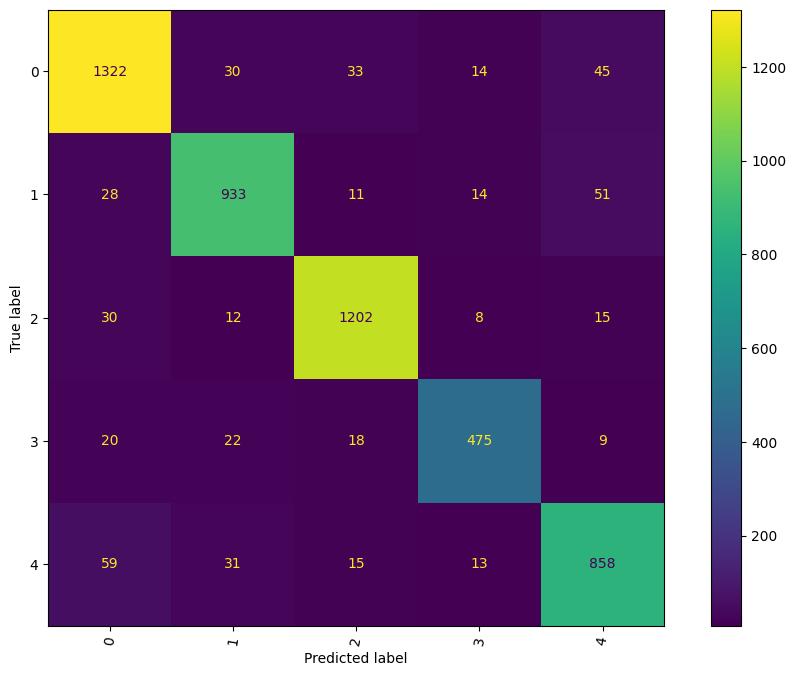

In [194]:
# Logistic Regression with GridSearchCV

# logistic regression
log_reg = LogisticRegression()

# hyperparameter for Logistic Regression
log_params = {'C': [0.01, 1, 10],
          'penalty': ['l2'],
          'solver': ['liblinear','newton-cg','saga']
         }

# create gridsearch object
grid_search_log = grid_search(log_reg, folds, log_params, scoring=None)

# fit model
grid_search_log.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_log)

# Random Forest Classification Report
metric6=[]
display_classification_report(grid_search_log,metric6)

### Decision Tree Classification with GridSearchCV

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.9320923433765378
Best Hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 30}
ROC AUC Score Train: 0.97
ROC AUC Score Test: 0.94
Train Accuracy : 0.81
Test Accuracy : 0.77
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82      4332
           1       0.80      0.84      0.82      3110
           2       0.85      0.86      0.86      3802
           3       0.74      0.74      0.74      1632
           4       0.78      0.73      0.76      2928

    accuracy                           0.81     15804
   macro avg       0.80      0.80      0.80     15804
weighted avg       0.81      0.81      0.81     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78      1444
           1       0.75      0.82      0.78      1037
           2       0.83      

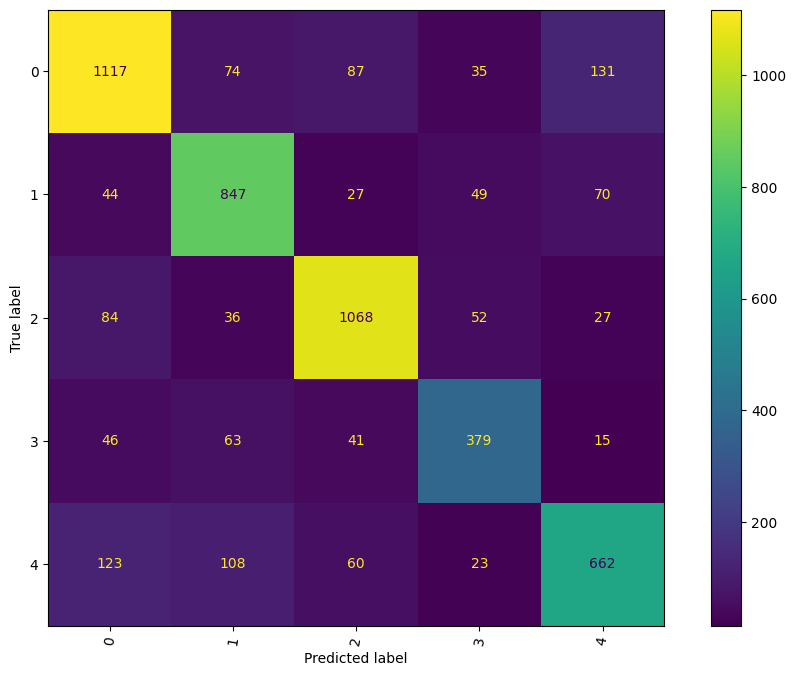

In [149]:
# Decision Tree Classification wuth GridSearchCV

dtc = DecisionTreeClassifier(random_state=40)

dtc_params = {
    'max_depth': [5,10,20,30],
    'min_samples_leaf': [5,10,20,30]
}

# create gridsearch object
grid_search_dtc = grid_search(dtc, folds, dtc_params, scoring='roc_auc_ovr')

# fit model
grid_search_dtc.fit(X_train, y_train)

# print best hyperparameters
print_best_score_params(grid_search_dtc)

# Random Forest Classification Report
metric7=[]
display_classification_report(grid_search_dtc,metric7)

### Random Forest Classifier with GridSearchCV

Fitting 5 folds for each of 80 candidates, totalling 400 fits
OOB SCORE : 0.8048595292331056
Best Score:  0.9715557838378521
Best Hyperparameters:  {'max_depth': 40, 'min_samples_leaf': 5, 'n_estimators': 700}
ROC AUC Score Train: 0.99
ROC AUC Score Test: 0.97
Train Accuracy : 0.91
Test Accuracy : 0.81
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      4332
           1       0.94      0.91      0.93      3110
           2       0.91      0.96      0.94      3802
           3       0.96      0.76      0.85      1632
           4       0.96      0.85      0.90      2928

    accuracy                           0.91     15804
   macro avg       0.93      0.89      0.91     15804
weighted avg       0.92      0.91      0.91     15804

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.74      0.93      0.82      1444
           1       0.83      0.

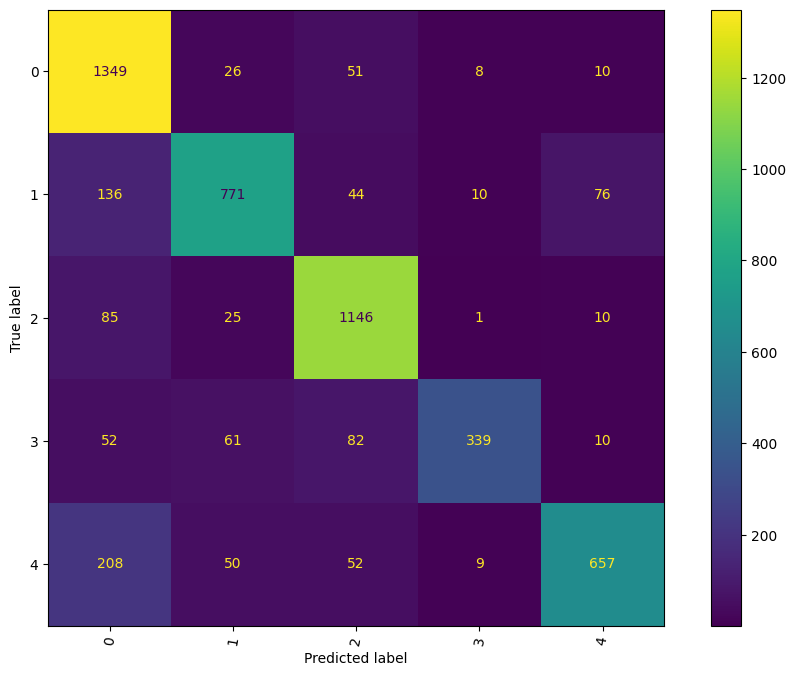

In [150]:
# Random Forest Classifier with GridSearchCV

rfc = RandomForestClassifier(random_state=40, n_jobs = -1,oob_score=True)

# hyperparameters for Random Forest
rfc_params = {'max_depth': [10,20,30,40],
          'min_samples_leaf': [5,10,15,20,30],
          'n_estimators': [100,200,500,700]
        }

# create gridsearch object
grid_search_rfc = grid_search(rfc, folds, rfc_params, scoring='roc_auc_ovr')

# fit model
grid_search_rfc.fit(X_train, y_train)

# oob score
print('OOB SCORE :',grid_search_rfc.best_estimator_.oob_score_)

# print best hyperparameters
print_best_score_params(grid_search_rfc)

# Random Forest Classification Report
metric8=[]
display_classification_report(grid_search_rfc,metric8)

# Model inference

### Consolidated view of all the models and their metrics

In [199]:
table = {'Metric': ['ROC_AUC Score(Train)','ROC_AUC Score(Test)',
                    'Accuracy(Train)','Accuracy(Test)',
                    'Precision(Train)','Precision(Test)',
                    'Recall(Train)','Recall(Test)',
                    'F1-Score(Train)','F1-Score(Test)'
                   ],
        'Multinomial Naive Bayes': metric1
        }

mnb_metric = pd.DataFrame(table ,columns = ['Metric', 'Multinomial Naive Bayes'] )
log_metric = pd.Series(metric2, name = 'Logistic Regression')
dtc_metric = pd.Series(metric3, name = 'Decision Tree Classifier')
rfc_metric = pd.Series(metric4, name = 'Random Forest Classifier')
grid_mnb_metric = pd.Series(metric5, name = 'Multinomial Naive Bayes with GridSearchCV')
grid_log_metric = pd.Series(metric6, name = 'Logistic Regression with GridSearchCV')
grid_dtc_metric = pd.Series(metric7, name = 'Decision Tree Classifier with GridSearchCV')
grid_rfc_metric = pd.Series(metric8, name = 'Random Forest Classifier with GridSearchCV')

final_metric = pd.concat([mnb_metric,log_metric,dtc_metric,rfc_metric,
                         grid_mnb_metric,grid_log_metric,grid_dtc_metric,grid_rfc_metric], axis = 1)

final_metric

,Metric,Multinomial Naive Bayes,Logistic Regression,Decision Tree Classifier,Random Forest Classifier,Multinomial Naive Bayes with GridSearchCV,Logistic Regression with GridSearchCV,Decision Tree Classifier with GridSearchCV,Random Forest Classifier with GridSearchCV
0,ROC_AUC Score(Train),0.95,1.00,1.00,1.00,0.98,1.00,0.97,0.99
1,ROC_AUC Score(Test),0.93,0.99,0.85,0.98,0.95,0.99,0.94,0.97
2,Accuracy(Train),0.68,0.95,1.00,1.00,0.85,1.00,0.81,0.91
3,Accuracy(Test),0.64,0.90,0.76,0.83,0.76,0.91,0.77,0.81
4,Precision(Train),0.76,0.95,1.00,1.00,0.85,1.00,0.81,0.92
5,Precision(Test),0.72,0.90,0.76,0.84,0.76,0.91,0.77,0.82
6,Recall(Train),0.68,0.95,1.00,1.00,0.85,1.00,0.81,0.91
7,Recall(Test),0.64,0.90,0.76,0.83,0.76,0.91,0.77,0.81
8,F1-Score(Train),0.66,0.95,1.00,1.00,0.85,1.00,0.81,0.91
9,F1-Score(Test),0.61,0.90,0.76,0.83,0.75,0.91,0.77,0.81


# Complaint Prediction using the best model above

### The best model looks to be Logistic Regression with GridSearchCV

In [207]:
# raw complaint text
test_complaint= 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [208]:
# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

In [209]:
# predict
prediction=grid_search_log.predict(test_tfidf)
prediction

array([1])

In [210]:
Topic_names[prediction[0]]

'Credit card or prepaid card'

In [211]:
test_complaint= "I am deeply disappointed by the poor level of customer service I received while attempting to resolve an issue with my bank account. The lack of responsiveness, misinformation, and prolonged wait times have left me feeling frustrated and undervalued as a customer"

In [212]:
# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

In [213]:
# predict
prediction=grid_search_log.predict(test_tfidf)
prediction

array([0])

In [214]:
Topic_names[prediction[0]]

'Bank Account services'

In [215]:
test_complaint="Yesterday, I received a fraudulent email regarding renewal of my services."

In [216]:
# vectorize and tf-idf tranform
test = count_vect.transform([test_complaint])
test_tfidf = tfidf_transformer.transform(test)

In [217]:
# predict
prediction=grid_search_log.predict(test_tfidf)
prediction

array([4])

In [218]:
Topic_names[prediction[0]]

'Mortgage/Loan'